In [1]:
import numpy as np
import matplotlib.pyplot as plt
import getdist
from getdist import plots, MCSamples
import pydelfi.priors as priors
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import tensorflow as tf
import simulators.cosmic_shear.cosmic_shear as cosmic_shear
import pickle
import pydelfi.score as score
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
### SET UP THE SIMULATOR ###

# Set up the tomography simulations
CosmicShearSimulator = cosmic_shear.TomographicCosmicShear(pz = pickle.load(open('simulators/cosmic_shear/pz_5bin.pkl', 'rb')),
                                                           lmin = 10, lmax = 1000, n_ell_bins = 5, 
                                                           sigma_e = 0.3, nbar = 30, Area = 15000)

# Simulator function: This must be of the form simulator(theta, seed, args) -> simulated data vector
def simulator(theta, seed, simulator_args, batch=1):
    return CosmicShearSimulator.simulate(theta, seed)

# Simulator arguments
simulator_args = None

In [3]:
### SET UP THE PRIOR ###

# Define the priors parameters
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
prior_covariance = np.eye(5)*np.array([0.1, 0.1, 0.05, 0.3, 0.3])**2

# Prior
prior = priors.TruncatedGaussian(prior_mean, prior_covariance, lower, upper)

In [4]:
### SET UP THE COMPRESSOR ###

# Fiducial parameters
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])

# Expected support of Wishart likelihood (fiducial inverse power spectrum)
C = CosmicShearSimulator.power_spectrum(theta_fiducial)
Cinv = np.array([np.linalg.inv(C[l,:,:]) for l in range(CosmicShearSimulator.n_ell_bins)])

# Degrees of freedom (effective number of modes per band power)
nl = CosmicShearSimulator.nl

# Calculate derivatives of the expected power spectrum
step = np.array(abs(theta_fiducial)*np.array([0.05, 0.05, 0.05, 0.05, 0.05]))
dCdt = CosmicShearSimulator.compute_derivatives(theta_fiducial, step)

# Define compression as score-MLE of a Wishart likelihood
Compressor = score.Wishart(theta_fiducial, nl, Cinv, dCdt, prior_mean=prior_mean, prior_covariance=prior_covariance)

# Pull out Fisher matrix inverse
Finv = Compressor.Finv

# Compressor function: This must have the form compressor(data, args) -> compressed summaries (pseudoMLE)
def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args = None

In [5]:
### GENERATE MOCK DATA VECTOR ###

seed = 0
data = simulator(theta_fiducial, seed, simulator_args)

compressed_data = compressor(data, compressor_args)

In [6]:
# Create an ensemble of NDEs
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=5, n_data=5, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=0),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=5)]

# Create the DELFI object
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, Finv=Finv, theta_fiducial=theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s'], 
                       results_dir = "simulators/cosmic_shear/results/",
                       input_normalization='fisher')


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Sampling approximate posterior...
Done.
Removed no burn in


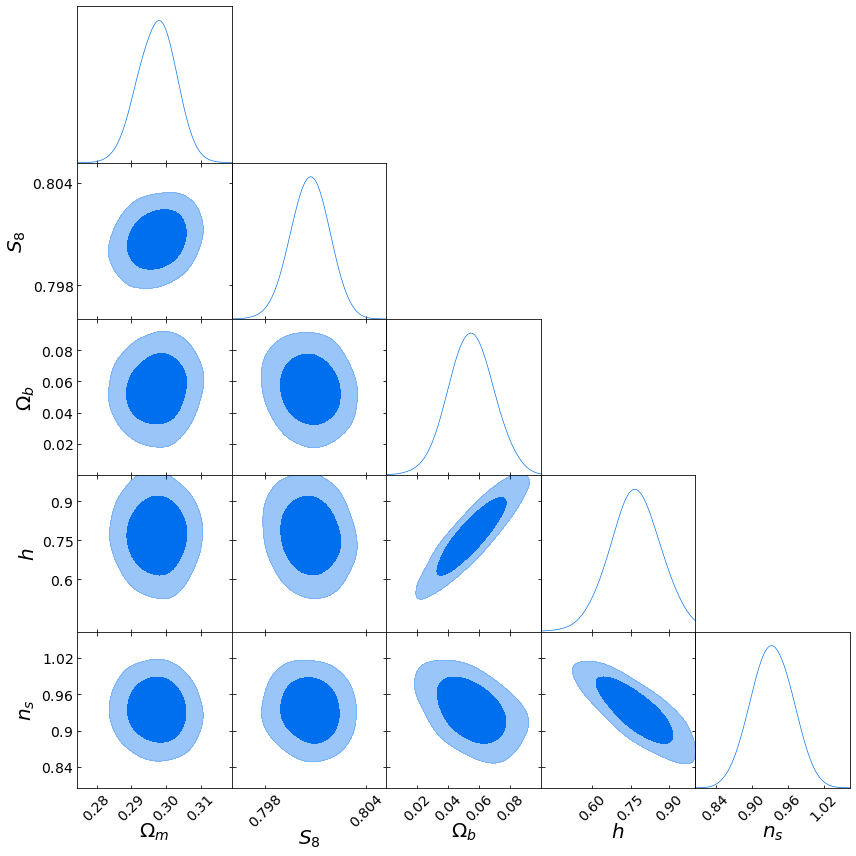

In [7]:
# Do the Fisher pre-training
DelfiEnsemble.fisher_pretraining()

simulators/cosmic_shear/results/graph_checkpoint


simulators/cosmic_shear/results/graph_checkpoint


simulators/cosmic_shear/results/graph_checkpoint


simulators/cosmic_shear/results/graph_checkpoint


simulators/cosmic_shear/results/graph_checkpoint


simulators/cosmic_shear/results/graph_checkpoint
Sampling approximate posterior...
Done.
Removed no burn in


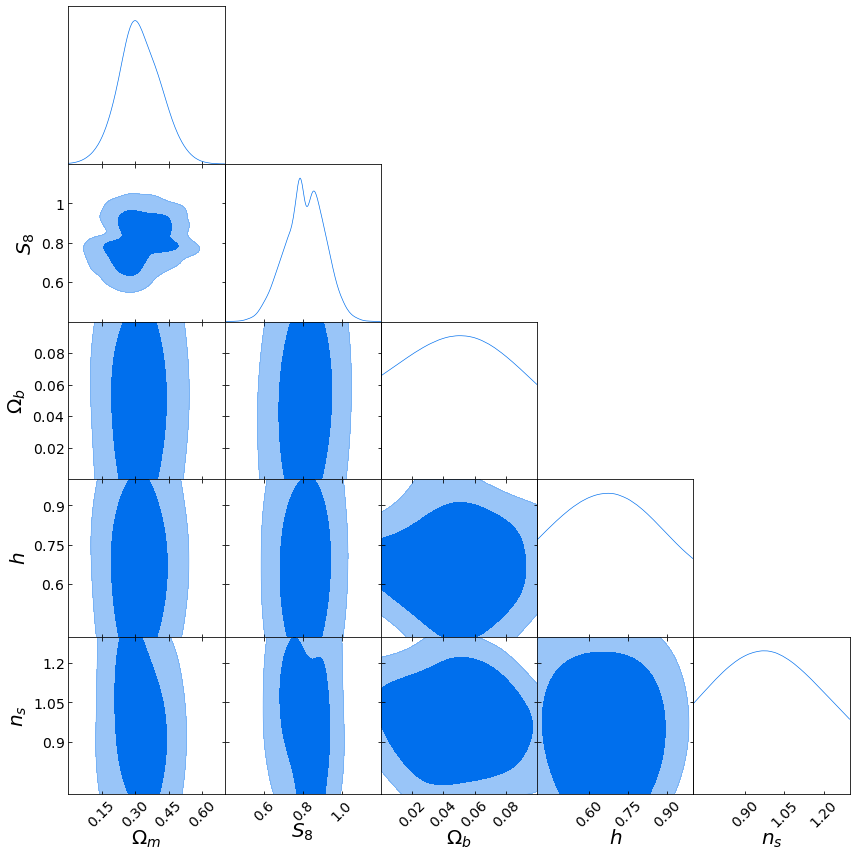

Population 1/10
Sampling proposal density...
Done.


Simulator returns exception for parameter values: [0.11664828 0.77929362 0.05618487 0.98127324 1.02198178] (rank 0)
Simulator returns exception for parameter values: [0.12028455 0.75212651 0.06525392 0.80416188 1.09865597] (rank 0)
Simulator returns exception for parameter values: [0.15896314 0.76045443 0.06544105 0.7883475  1.0678787 ] (rank 0)
Simulator returns exception for parameter values: [0.16212245 0.75982524 0.06680922 0.7801197  1.06426523] (rank 0)
Simulator returns exception for parameter values: [0.16212245 0.75982524 0.06680922 0.7801197  1.06426523] (rank 0)
Simulator returns exception for parameter values: [0.11881204 0.82595291 0.05984233 0.7826123  1.02350557] (rank 0)
Simulator returns exception for parameter values: [0.11881204 0.82595291 0.05984233 0.7826123  1.02350557] (rank 0)
Simulator returns exception for parameter values: [0.11881204 0.82595291 0.05984233 0.7826123  1.02350557] (rank 0)
Simulator returns exception for parameter values: [0.17242223 0.84089537

/home/thomas/Thesis/pydelfi/examples/simulators/cosmic_shear/cosmology.py:637: RuntimeWarning: invalid value encountered in double_scalars
  beta_c = 1.0 + b1*(pow(fc, b2) - 1.0)


In [ ]:
# Initial samples, batch size for population samples, number of populations
n_initial = 100
n_batch = 100
n_populations = 10

# Do the SNL training
DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=10, save_intermediate_posteriors=True)